In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_info_columns', 999)

In [3]:
PLOT_LOCS = '../data/processed/blm_usfs_wadnr_plot_footprints.shp'
CLIMATE = '../data/processed/pnw_lidar_plots_climatewna_2000-2017MSY.csv'
CLOUDMETS = '../data/processed/lidar/plot_clips/cloudmetrics.csv'
GRIDSURF = '../data/processed/lidar/plot_clips/gridsurfacestats.csv'
TOPOMETS = '../data/processed/lidar/plot_clips/topometrics.csv'
SOILS = '../data/processed/soils/soils_data_forPlots.csv'
POTVEG = '../data/processed/pot_veg/pot_veg_plots.csv'
WATER = '../data/interim/dist_to_water/water_distance_fromPlots.csv'
LANDSAT = '../data/interim/landsat_metrics.csv'
FVS = '../data/processed/fvs_outputs/fvs_outputs.csv'
ECOREGIONS = '../data/raw/epa/us_eco_l3_state_boundaries.shp'

In [4]:
plot_locs = gpd.read_file(PLOT_LOCS)
plot_locs['uuid_part'] = plot_locs['uuid'].apply(lambda x: x.split('-')[0])
plot_locs['geometry'] = plot_locs.centroid

In [5]:
ecoreg = gpd.read_file(ECOREGIONS)
ecoreg = ecoreg.loc[ecoreg.STATE_NAME.isin(['Washington', 'Oregon'])]
ecoreg['ecoregion3'] = ecoreg.US_L3NAME.str.lower().str.replace(' ', '_').str.replace('/', '_')
ecoreg.crs = {'init': 'epsg:5070'}
ecoreg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 82 entries, 15 to 1630
Data columns (total 15 columns):
US_L3CODE     82 non-null object
US_L3NAME     82 non-null object
NA_L3CODE     82 non-null object
NA_L3NAME     82 non-null object
NA_L2CODE     82 non-null object
NA_L2NAME     82 non-null object
NA_L1CODE     82 non-null object
NA_L1NAME     82 non-null object
STATE_NAME    82 non-null object
EPA_REGION    82 non-null int64
L3_KEY        82 non-null object
L2_KEY        82 non-null object
L1_KEY        82 non-null object
geometry      82 non-null object
ecoregion3    82 non-null object
dtypes: int64(1), object(14)
memory usage: 10.2+ KB


In [6]:
# add the ecoregion to the plot table
ecoreg_cols = ecoreg.columns.drop('geometry')
ecoreg_join = gpd.sjoin(plot_locs.to_crs(epsg=5070), ecoreg.to_crs(epsg=5070), how='left').drop(['index_right'], axis=1)
ecoreg_join.loc[ecoreg_join.uuid_part == '9d4ab655', ecoreg_cols] = ecoreg.loc[ecoreg.ecoregion3 == 'puget_lowland', ecoreg_cols].drop_duplicates().values

In [7]:
uuid_lookup = plot_locs[['uuid', 'uuid_part']].set_index('uuid_part')

In [8]:
KEEP_PLOT_COLS = ['lat', 'lon', 'orig_id', 'uuid', 'source', 'meas_yr', 'ecoregion3']
plot_info = ecoreg_join[KEEP_PLOT_COLS]

plot_info.loc[plot_info.source.str.contains('USFS'), 'agency'] = 'USFS'
plot_info.loc[plot_info.source.str.contains('BLM'), 'agency'] = 'BLM'
plot_info.loc[plot_info.source.str.contains('WA-DNR'), 'agency'] = 'WADNR'

plot_info.loc[plot_info.agency == 'USFS', 'plot_size_ac'] = 1/4
plot_info.loc[plot_info.agency == 'BLM', 'plot_size_ac'] = 1/8
plot_info.loc[plot_info.agency == 'WADNR', 'plot_size_ac'] = 1/10

plot_info.info()

/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5089 entries, 0 to 5088
Data columns (total 9 columns):
lat             5089 non-null float64
lon             5089 non-null float64
orig_id         5089 non-null object
uuid            5089 non-null object
source          5089 non-null object
meas_yr         5089 non-null int64
ecoregion3      5089 non-null object
agency          5089 non-null object
plot_size_ac    5089 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 397.6+ KB


In [9]:
climate = pd.read_csv(CLIMATE).rename(
    {'Year': 'year', 'ID1':'uuid_part', 'ID2':'source'},
    axis=1)

In [10]:
climate['uuid'] = uuid_lookup.loc[climate.uuid_part.values].values[:,0]
climate = climate.set_index(['uuid', 'year'])

In [11]:
# breaking the climatena columns into groups
MONTHLY_COLS = ['Tmax01','Tmax02','Tmax03','Tmax04','Tmax05','Tmax06',
                'Tmax07','Tmax08','Tmax09','Tmax10','Tmax11','Tmax12',
                'Tmin01','Tmin02','Tmin03','Tmin04','Tmin05','Tmin06',
                'Tmin07','Tmin08','Tmin09','Tmin10','Tmin11','Tmin12',
                'Tave01','Tave02','Tave03','Tave04','Tave05','Tave06',
                'Tave07','Tave08','Tave09','Tave10','Tave11','Tave12',
                'PPT01','PPT02','PPT03','PPT04','PPT05','PPT06',
                'PPT07','PPT08','PPT09','PPT10','PPT11','PPT12',
                'Rad01','Rad02','Rad03','Rad04','Rad05','Rad06',
                'Rad07','Rad08','Rad09','Rad10','Rad11','Rad12',
                'DD_0_01','DD_0_02','DD_0_03','DD_0_04','DD_0_05','DD_0_06',
                'DD_0_07','DD_0_08','DD_0_09','DD_0_10','DD_0_11','DD_0_12',
                'DD5_01','DD5_02','DD5_03','DD5_04','DD5_05','DD5_06',
                'DD5_07','DD5_08','DD5_09','DD5_10','DD5_11','DD5_12',
                'DD_18_01','DD_18_02','DD_18_03','DD_18_04','DD_18_05','DD_18_06',
                'DD_18_07','DD_18_08','DD_18_09','DD_18_10','DD_18_11','DD_18_12',
                'DD18_01','DD18_02','DD18_03','DD18_04','DD18_05','DD18_06',
                'DD18_07','DD18_08','DD18_09','DD18_10','DD18_11','DD18_12',
                'NFFD01','NFFD02','NFFD03','NFFD04','NFFD05','NFFD06',
                'NFFD07','NFFD08','NFFD09','NFFD10','NFFD11','NFFD12',
                'PAS01','PAS02','PAS03','PAS04','PAS05','PAS06',
                'PAS07','PAS08','PAS09','PAS10','PAS11','PAS12',
                'Eref01','Eref02','Eref03','Eref04','Eref05','Eref06',
                'Eref07','Eref08','Eref09','Eref10','Eref11','Eref12',
                'CMD01','CMD02','CMD03','CMD04','CMD05','CMD06',
                'CMD07','CMD08','CMD09','CMD10','CMD11','CMD12',
                'RH01','RH02','RH03','RH04','RH05','RH06',
                'RH07','RH08','RH09','RH10','RH11','RH12']
SEASON_COLS = ['Tmax_wt','Tmax_sp','Tmax_sm','Tmax_at',
               'Tmin_wt','Tmin_sp','Tmin_sm','Tmin_at',
               'Tave_wt','Tave_sp','Tave_sm','Tave_at',
               'PPT_wt','PPT_sp','PPT_sm','PPT_at',
               'Rad_wt','Rad_sp','Rad_sm','Rad_at',
               'DD_0_wt','DD_0_sp','DD_0_sm','DD_0_at',
               'DD5_wt','DD5_sp','DD5_sm','DD5_at',
               'DD_18_wt','DD_18_sp','DD_18_sm','DD_18_at',
               'DD18_wt','DD18_sp','DD18_sm','DD18_at',
               'NFFD_wt','NFFD_sp','NFFD_sm','NFFD_at',
               'PAS_wt','PAS_sp','PAS_sm','PAS_at',
               'Eref_wt','Eref_sp','Eref_sm','Eref_at',
               'CMD_wt','CMD_sp','CMD_sm','CMD_at',
               'RH_wt','RH_sp','RH_sm','RH_at']
ANN_COLS = ['MAT','MWMT','MCMT','TD','MAP','MSP',
            'AHM','SHM','DD_0','DD5','DD_18','DD18',
            'NFFD','bFFP','eFFP','FFP','PAS','EMT',
            'EXT','MAR','Eref','CMD','RH']

In [12]:
climate_season = climate[SEASON_COLS].replace(-9999.0, np.nan).drop(['Rad_wt','Rad_sp','Rad_sm','Rad_at'], axis=1)
climate_annual = climate[ANN_COLS].replace(-9999.0, np.nan).drop('MAR', axis=1)
climate_season.columns = [col.lower() for col in climate_season.columns]
climate_annual.columns = [col.lower() for col in climate_annual.columns]

In [13]:
climate_annual.head()

,,mat,mwmt,mcmt,td,map,msp,ahm,shm,dd_0,dd5,dd_18,dd18,nffd,bffp,effp,ffp,pas,emt,ext,eref,cmd,rh
uuid,year,,,,,,,,,,,,,,,,,,,,,,
d7c01e3a-38e0-4bc2-a69c-7d5a204e2663,2000,5.0,15.4,-2.8,18.2,1019,119,14.7,129.9,542,1233,4733,30,172,156,261,105,365,-33.4,34.5,655,428,62
c16be14e-f913-4516-9c4b-078b3d71371d,2000,6.6,17.3,-1.3,18.6,680,89,24.5,194.2,395,1566,4199,71,184,151,267,116,159,-32.3,36.9,789,536,58
b4e059b8-6f08-4d33-8c3c-2b0410d2a226,2000,4.4,14.7,-3.2,17.9,1019,127,14.2,116.1,596,1106,4948,21,165,161,259,98,403,-33.9,33.9,625,395,63
e3b77390-f724-4a58-ad90-0b97cb138ce8,2000,7.0,17.7,-1.4,19.0,583,96,29.2,184.2,380,1666,4086,88,185,148,267,119,125,-33.2,37.5,811,551,56
5588b367-b5dc-4b23-9af3-bcf0d6e2a571,2000,4.5,14.8,-3.2,18.0,1033,128,14.0,115.1,596,1112,4940,22,167,159,260,101,407,-33.8,33.8,621,390,64


In [14]:
climate_annual.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 91602 entries, (d7c01e3a-38e0-4bc2-a69c-7d5a204e2663, 2000) to (4214cf54-1e3f-45d3-b93c-80c965cb3314, 2017)
Data columns (total 22 columns):
mat      91602 non-null float64
mwmt     91602 non-null float64
mcmt     91602 non-null float64
td       91602 non-null float64
map      91602 non-null int64
msp      91602 non-null int64
ahm      91602 non-null float64
shm      91602 non-null float64
dd_0     91602 non-null int64
dd5      91602 non-null int64
dd_18    91602 non-null int64
dd18     91602 non-null int64
nffd     91602 non-null int64
bffp     91602 non-null int64
effp     91602 non-null int64
ffp      91602 non-null int64
pas      91602 non-null int64
emt      91602 non-null float64
ext      91602 non-null float64
eref     91602 non-null int64
cmd      91602 non-null int64
rh       91602 non-null int64
dtypes: float64(8), int64(14)
memory usage: 15.7+ MB


In [15]:
climate_season.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 91602 entries, (d7c01e3a-38e0-4bc2-a69c-7d5a204e2663, 2000) to (4214cf54-1e3f-45d3-b93c-80c965cb3314, 2017)
Data columns (total 52 columns):
tmax_wt     91602 non-null float64
tmax_sp     91602 non-null float64
tmax_sm     91602 non-null float64
tmax_at     91602 non-null float64
tmin_wt     91602 non-null float64
tmin_sp     91602 non-null float64
tmin_sm     91602 non-null float64
tmin_at     91602 non-null float64
tave_wt     91602 non-null float64
tave_sp     91602 non-null float64
tave_sm     91602 non-null float64
tave_at     91602 non-null float64
ppt_wt      91602 non-null int64
ppt_sp      91602 non-null int64
ppt_sm      91602 non-null int64
ppt_at      91602 non-null int64
dd_0_wt     91602 non-null int64
dd_0_sp     91602 non-null int64
dd_0_sm     91602 non-null int64
dd_0_at     91602 non-null int64
dd5_wt      91602 non-null int64
dd5_sp      91602 non-null int64
dd5_sm      91602 non-null int64
dd5_at      91602 non-null

In [16]:
cloudmets = pd.read_csv(CLOUDMETS, low_memory=False)
cloudmets['uuid'] = cloudmets.FileTitle.apply(lambda x: x.split('_')[0])
cloudmets['lidar_year'] = cloudmets.FileTitle.apply(lambda x: int(x.split('_')[-1].split('-')[-1]))
cloudmets['lidar_acq'] = cloudmets.FileTitle.apply(lambda x: '_'.join(x.split('_')[1:3]))

In [17]:
RENAME_COLS = {'Total return count': 'num_returns',
               'Elev strata (below 0.15) return proportion':'strat0_return-proportion',
               'Elev strata (0.15 to 1.37) return proportion':'strat1_return-proportion',
               'Elev strata (5.00 to 10.00) return proportion':'strat2_return-proportion',
               'Elev strata (10.00 to 20.00) return proportion':'strat3_return-proportion',
               'Elev strata (20.00 to 30.00) return proportion':'strat4_return-proportion',
               'Elev strata (above 30.00) return proportion':'strat5_return-proportion',
               'Int strata (below 0.15) median':'strat0_intensity-median',
               'Int strata (0.15 to 1.37) median':'strat1_intensity-median',
               'Int strata (1.37 to 5.00) median':'strat2_intensity-median',
               'Int strata (5.00 to 10.00) median':'strat3_intensity-median',
               'Int strata (10.00 to 20.00) median':'strat4_intensity-median',
               'Int strata (above 30.00) median':'strat5_intensity-median',
               'Elev P05':'height_05-percentile','Elev P25':'height_25-percentile',
               'Elev P50':'height_50-percentile',
               'Elev P75':'height_75-percentile',
               'Elev P95':'height_95_percentile',
               'Elev maximum':'height_max',
               'Percentage all returns above 1.37':'cover'}

In [18]:
cloudmets = cloudmets.rename(RENAME_COLS, axis=1)
KEEP_COLS = [col for col in RENAME_COLS.values()] + ['uuid', 'lidar_acq', 'lidar_year']
cloudmets = cloudmets[KEEP_COLS].set_index(['uuid', 'lidar_year'])
cloudmets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5135 entries, (aef73d5b-3e3d-4519-802f-a09c591a8931, 2014) to (80c46ebf-c0c0-4597-8fab-267573b28f91, 2014)
Data columns (total 21 columns):
num_returns                 5135 non-null int64
strat0_return-proportion    5135 non-null float64
strat1_return-proportion    5135 non-null float64
strat2_return-proportion    5135 non-null float64
strat3_return-proportion    5135 non-null float64
strat4_return-proportion    5135 non-null float64
strat5_return-proportion    5135 non-null float64
strat0_intensity-median     5135 non-null float64
strat1_intensity-median     5135 non-null float64
strat2_intensity-median     5135 non-null float64
strat3_intensity-median     5135 non-null float64
strat4_intensity-median     5135 non-null float64
strat5_intensity-median     5135 non-null float64
height_05-percentile        5135 non-null float64
height_25-percentile        5135 non-null float64
height_50-percentile        5135 non-null float64
height_75-pe

In [19]:
cloudmets.head()

,,num_returns,strat0_return-proportion,strat1_return-proportion,strat2_return-proportion,strat3_return-proportion,strat4_return-proportion,strat5_return-proportion,strat0_intensity-median,strat1_intensity-median,strat2_intensity-median,strat3_intensity-median,strat4_intensity-median,strat5_intensity-median,height_05-percentile,height_25-percentile,height_50-percentile,height_75-percentile,height_95_percentile,height_max,cover,lidar_acq
uuid,lidar_year,,,,,,,,,,,,,,,,,,,,,
aef73d5b-3e3d-4519-802f-a09c591a8931,2014,9856,0.030641,0.061181,0.013088,0.011769,0.015219,0.850244,41.5,45.0,64.0,55.0,78.5,82.0,0.4600,50.754997,78.820000,96.002502,110.462502,121.699997,90.817776,willapa-delivery2_2014
0f9c587f-efbc-49f5-8123-1912356bd73e,2006,636,0.023585,0.022013,0.000000,0.001572,0.001572,0.940252,8.0,12.5,5.0,-9999.0,-9999.0,14.0,2.0625,82.737503,99.854996,110.522499,120.052505,122.000000,95.440252,north-puget_2006
4ca85db2-ca72-4426-b53c-702421c3177c,2006,8162,0.060647,0.203136,0.034060,0.219677,0.125582,0.283631,26.0,26.0,22.0,19.0,20.0,17.0,0.0000,1.190000,15.520000,32.474998,55.609501,79.860001,73.621661,ahtanum_2006
b88e67f8-0f86-491a-bfbe-26196e0400b6,2002,546,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,puget-sound-lowlands_2002
600fdbb4-d4d1-462f-af11-8221ce698376,2006,2860,0.309091,0.490909,0.044406,0.085664,0.040210,0.008042,31.0,28.0,30.0,27.0,26.0,30.0,0.0000,0.000000,0.420000,0.830000,19.513000,37.590000,20.000000,ahtanum_2006


In [20]:
gridsurf = pd.read_csv(GRIDSURF)
gridsurf['uuid'] = gridsurf.plot_id.apply(lambda x: x.split('_')[0])
gridsurf['lidar_year'] = gridsurf.plot_id.apply(lambda x: int(x.split('_')[-1].split('-')[-1]))
KEEP_COLS = ['uuid', 'lidar_year', 'potential_volume', 'stddev_height',
             'surface_area_ratio', 'surface_volume', 'surface_volume_ratio']
gridsurf = gridsurf[KEEP_COLS].set_index(['uuid', 'lidar_year'])
gridsurf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5135 entries, (00027724-39d2-42b3-954d-cf2dbe527a44, 2015) to (fff7e1c3-5bb4-4eaf-b92c-ed417421aaf3, 2008)
Data columns (total 5 columns):
potential_volume        5135 non-null float64
stddev_height           5135 non-null float64
surface_area_ratio      5135 non-null float64
surface_volume          5135 non-null float64
surface_volume_ratio    4830 non-null float64
dtypes: float64(5)
memory usage: 249.3+ KB


In [21]:
gridsurf.head()

potential_volume  \
uuid                                 lidar_year                     
00027724-39d2-42b3-954d-cf2dbe527a44 2015                    94.0   
0080963b-a3ff-4081-be77-02eb7b458d30 2008                  5046.0   
0083eb5e-aed6-4c22-9412-bc116d072ed9 2006                  2658.0   
008dc9d1-d2a0-4ee5-ba75-592318d06c1b 2013                  3718.5   
                                     2016                  3895.0   

                                                 stddev_height  \
uuid                                 lidar_year                  
00027724-39d2-42b3-954d-cf2dbe527a44 2015             0.079546   
0080963b-a3ff-4081-be77-02eb7b458d30 2008            11.256773   
0083eb5e-aed6-4c22-9412-bc116d072ed9 2006             8.932764   
008dc9d1-d2a0-4ee5-ba75-592318d06c1b 2013             2.579358   
                                     2016             2.444401   

                                                 surface_area_ratio  \
uuid                                 lidar_year                       
00027724-39d2-42b3-954d-cf2dbe527a44 2015                  1.024375   
0080963b-a3ff-4081-be77-02eb7b458d30 2008                  7.121909   
0083eb5e-aed6-4c22-9412-bc116d072ed9 2006                  6.092628   
008dc9d1-d2a0-4ee5-ba75-592318d06c1b 2013                  2.883042   
                                     2016                  2.553517   

                                                 surface_volume  \
uuid                                 lidar_year                   
00027724-39d2-42b3-954d-cf2dbe527a44 2015              1.406838   
0080963b-a3ff-4081-be77-02eb7b458d30 2008           3391.452148   
0083eb5e-aed6-4c22-9412-bc116d072ed9 2006            831.681885   
008dc9d1-d2a0-4ee5-ba75-592318d06c1b 2013           3173.707031   
                                     2016           3310.491699   

                                                 surface_volume_ratio  
uuid                                 lidar_year                        
00027724-39d2-42b3-954d-cf2dbe527a44 2015                    0.025674  
0080963b-a3ff-4081-be77-02eb7b458d30 2008                    0.717014  
0083eb5e-aed6-4c22-9412-bc116d072ed9 2006                    0.312898  
008dc9d1-d2a0-4ee5-ba75-592318d06c1b 2013                    0.860225  
                                     2016                    0.869114

In [22]:
topomets = pd.read_csv(TOPOMETS)
topomets['uuid'] = topomets.plot_id.apply(lambda x: x.split('_')[0])
topomets['lidar_year'] = topomets.plot_id.apply(lambda x: int(x.split('_')[-1].split('-')[-1]))
topomets = topomets.drop('plot_id', axis=1).set_index(['uuid', 'lidar_year'])
topomets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5135 entries, (00027724-39d2-42b3-954d-cf2dbe527a44, 2015) to (fff7e1c3-5bb4-4eaf-b92c-ed417421aaf3, 2008)
Data columns (total 7 columns):
aspect                   5069 non-null float64
elevation                5135 non-null float64
overall_curvature        5069 non-null float64
plan_curvature           5069 non-null float64
profile_curvature        5069 non-null float64
slope                    5069 non-null float64
solar_radiation_index    5069 non-null float64
dtypes: float64(7)
memory usage: 329.5+ KB


In [23]:
soils = pd.read_csv(SOILS, index_col = 'uuid')
soils.columns = [col.lower() for col in soils.columns]
KEEP_SOILS = ['bulk_dens', 'soil_depth', 'pct_clay_surf', 'pct_rock_surf', 'pct_sand_surf']
soils = soils[KEEP_SOILS]
soils.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5089 entries, 075cbfbc-f210-49f9-9f4e-2133b16ac2ec to 25d94682-4fb4-466a-8345-851d5a0d7bbf
Data columns (total 5 columns):
bulk_dens        5089 non-null int64
soil_depth       5089 non-null float64
pct_clay_surf    5089 non-null int64
pct_rock_surf    5089 non-null int64
pct_sand_surf    5089 non-null int64
dtypes: float64(1), int64(4)
memory usage: 238.5+ KB


In [24]:
soils.head()

,bulk_dens,soil_depth,pct_clay_surf,pct_rock_surf,pct_sand_surf
uuid,,,,,
075cbfbc-f210-49f9-9f4e-2133b16ac2ec,135,140.0,9,24,48
ca06b2b7-5e93-453b-b31a-7411d57b0a31,92,127.0,13,24,42
3464eb42-56a2-486e-bd6a-39d9cc7d25f9,125,160.0,15,6,31
0c159329-d696-4cf1-a59d-a9b0dd9885a1,102,113.0,14,17,37
f6358940-c502-4128-a88e-38d0fa359d33,102,113.0,14,17,37


In [25]:
potveg = pd.read_csv(POTVEG, index_col='uuid')
potveg.columns = [col.lower() for col in potveg.columns]
potveg = potveg.rename({'esp2':'pot_veg_type'}, axis=1)
potveg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5089 entries, 0fc9bef5-f82b-4af9-932a-8c064a339807 to 25d94682-4fb4-466a-8345-851d5a0d7bbf
Data columns (total 8 columns):
value           5089 non-null int64
oid_            5089 non-null int64
mz              5089 non-null int64
zone_name       5089 non-null object
pot_veg_type    5089 non-null int64
esp_name        5089 non-null object
esp_lf          5089 non-null int64
esplf_name      5089 non-null object
dtypes: int64(5), object(3)
memory usage: 357.8+ KB


In [26]:
potveg.head()

,value,oid_,mz,zone_name,pot_veg_type,esp_name,esp_lf,esplf_name
uuid,,,,,,,,
0fc9bef5-f82b-4af9-932a-8c064a339807,549,408,1,Northern Cascades,1178,North Pacific Hypermaritime Western Red-cedar-...,5,Upland Forest
e3f1682b-aeb2-4bf6-a20a-9f34775f9f86,97,97,1,Northern Cascades,1039,North Pacific Maritime Mesic-Wet Douglas-fir-W...,5,Upland Forest
f9fbe1a4-427a-4fc7-81ea-c73a64c6444d,97,97,1,Northern Cascades,1039,North Pacific Maritime Mesic-Wet Douglas-fir-W...,5,Upland Forest
a8b9dc65-264c-4878-a057-f6a7d748cef4,77,77,1,Northern Cascades,1037,North Pacific Maritime Dry-Mesic Douglas-fir-W...,5,Upland Forest
f70c4a18-6312-4039-8ff2-263626a62d68,549,408,1,Northern Cascades,1178,North Pacific Hypermaritime Western Red-cedar-...,5,Upland Forest


In [27]:
landsat = pd.read_csv(LANDSAT, index_col=['uuid', 'year']).drop('source', axis=1)
landsat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 86513 entries, (f646c521-31b0-4567-898c-d4a27422b5c2, 2002) to (2ea15f7d-f4f5-4125-aff8-1f5c72b3b169, 2018)
Data columns (total 12 columns):
green         82471 non-null float64
blue          82471 non-null float64
red           82471 non-null float64
nir           82471 non-null float64
endvi         82471 non-null float64
ndvi          82471 non-null float64
savi          82471 non-null float64
swir1         82471 non-null float64
swir2         82471 non-null float64
wetness       82471 non-null float64
greenness     82471 non-null float64
brightness    82471 non-null float64
dtypes: float64(12)
memory usage: 8.2+ MB


In [28]:
landsat.head()

,,green,blue,red,nir,endvi,ndvi,savi,swir1,swir2,wetness,greenness,brightness
uuid,year,,,,,,,,,,,,
f646c521-31b0-4567-898c-d4a27422b5c2,2002,471.693412,291.197852,414.169344,2128.877075,0.634134,0.675934,1.013700,1447.531182,712.798563,-106.251329,108.155288,235.320061
ce529ff1-a35d-4b97-ab44-5bf1c3b46731,2002,448.728468,281.513119,384.378287,1893.107702,0.612208,0.662206,0.993092,1261.750953,667.959718,-94.009805,93.630321,212.299320
75ff6bd4-88b3-46be-ae69-f2cfc6c18d04,2002,575.412711,339.793653,535.595238,2254.174572,0.612905,0.616818,0.925061,1757.976150,983.063477,-139.841463,104.347095,268.102042
78986eb4-cac2-4c81-866e-d1941e8180ab,2002,329.276805,192.131577,223.192984,1903.442521,0.706367,0.789872,1.184529,732.211490,324.636454,-40.079778,112.346049,176.469964
bc47424e-a736-4139-97b2-e2dbaee0ee4d,2002,626.951118,392.962073,614.204571,2370.380209,0.584216,0.588262,0.882244,2003.645721,1122.536913,-161.888053,104.353707,291.868012


In [29]:
water = pd.read_csv(WATER, index_col='uuid')
water.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5089 entries, 075cbfbc-f210-49f9-9f4e-2133b16ac2ec to 25d94682-4fb4-466a-8345-851d5a0d7bbf
Data columns (total 1 columns):
distance_to_water_m    5089 non-null float64
dtypes: float64(1)
memory usage: 79.5+ KB


In [30]:
water.head()

,distance_to_water_m
uuid,
075cbfbc-f210-49f9-9f4e-2133b16ac2ec,23.966350
ca06b2b7-5e93-453b-b31a-7411d57b0a31,249.961364
3464eb42-56a2-486e-bd6a-39d9cc7d25f9,382.598565
0c159329-d696-4cf1-a59d-a9b0dd9885a1,414.057799
f6358940-c502-4128-a88e-38d0fa359d33,110.280018


In [31]:
lidar_df = cloudmets.join(gridsurf).join(topomets).reset_index().drop_duplicates(subset=['uuid', 'lidar_acq'])
lidar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5135 entries, 0 to 5410
Data columns (total 35 columns):
uuid                        5135 non-null object
lidar_year                  5135 non-null int64
num_returns                 5135 non-null int64
strat0_return-proportion    5135 non-null float64
strat1_return-proportion    5135 non-null float64
strat2_return-proportion    5135 non-null float64
strat3_return-proportion    5135 non-null float64
strat4_return-proportion    5135 non-null float64
strat5_return-proportion    5135 non-null float64
strat0_intensity-median     5135 non-null float64
strat1_intensity-median     5135 non-null float64
strat2_intensity-median     5135 non-null float64
strat3_intensity-median     5135 non-null float64
strat4_intensity-median     5135 non-null float64
strat5_intensity-median     5135 non-null float64
height_05-percentile        5135 non-null float64
height_25-percentile        5135 non-null float64
height_50-percentile        5135 non-null float6

In [32]:
# loop through the lidar attributes, identify the nearest near in the joined dataframes
annual_features = lidar_df.copy().set_index(['uuid', 'lidar_year'])
seasonal_features = lidar_df.copy().set_index(['uuid', 'lidar_year'])
annual_cols = climate_annual.columns.append(landsat.columns)
seasonal_cols = climate_season.columns.append(landsat.columns)
annual_features = annual_features.reindex(annual_features.columns.append(annual_cols), axis=1)
seasonal_features = seasonal_features.reindex(seasonal_features.columns.append(seasonal_cols), axis=1)

uuids = []
best_clim_yrs = []
best_landsat_yrs = []

for idx, row in lidar_df.iterrows():
    uuid = row['uuid']
    lidar_yr = row['lidar_year']
    clim_yrs = climate_annual.loc[uuid].dropna(how='all').index.get_level_values('year')
    landsat_yrs = landsat.loc[uuid].dropna(how='all').index.get_level_values('year')
    
    # find the difference between lidar_yr and the climate/landsat years
    diff_clim_yr = abs(lidar_yr - clim_yrs)
    diff_landsat_yr = abs(lidar_yr - landsat_yrs)
    min_clim_idx = diff_clim_yr.argmin()
    min_landsat_idx = diff_landsat_yr.argmin()
    best_clim_yr = clim_yrs[min_clim_idx] # choose the closest fit
    best_landsat_yr = landsat_yrs[min_landsat_idx]
    uuids.append(uuid)
    best_clim_yrs.append(best_clim_yr)
    best_landsat_yrs.append(best_landsat_yr)

best_clim_idx = list(zip(uuids, best_clim_yrs))
best_landsat_idx = list(zip(uuids, best_landsat_yrs))

annual_features[climate_annual.columns] = climate_annual.reindex(best_clim_idx).values
seasonal_features[climate_season.columns] = climate_season.reindex(best_clim_idx).values
annual_features[landsat.columns] = landsat.reindex(best_landsat_idx).values
seasonal_features[landsat.columns] = landsat.reindex(best_landsat_idx).values

annual_features['landsat_year'] = best_landsat_yrs
seasonal_features['landsat_year'] = best_landsat_yrs
annual_features['clim_year'] = best_clim_yrs
seasonal_features['clim_year'] = best_clim_yrs

In [33]:
PERM_DFS = [water, soils, potveg[['pot_veg_type']]] 
perm_features = pd.concat(PERM_DFS, axis=1, sort=True)
perm_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5089 entries, 00027724-39d2-42b3-954d-cf2dbe527a44 to fff7e1c3-5bb4-4eaf-b92c-ed417421aaf3
Data columns (total 7 columns):
distance_to_water_m    5089 non-null float64
bulk_dens              5089 non-null int64
soil_depth             5089 non-null float64
pct_clay_surf          5089 non-null int64
pct_rock_surf          5089 non-null int64
pct_sand_surf          5089 non-null int64
pot_veg_type           5089 non-null int64
dtypes: float64(2), int64(5)
memory usage: 318.1+ KB


In [34]:
annual_features = annual_features.reindex(annual_features.columns.append(perm_features.columns), axis=1)
seasonal_features = seasonal_features.reindex(seasonal_features.columns.append(perm_features.columns), axis=1)

annual_features[perm_features.columns] = perm_features.reindex(annual_features.index.get_level_values('uuid')).values
seasonal_features[perm_features.columns] = perm_features.reindex(seasonal_features.index.get_level_values('uuid')).values

In [35]:
# add the plot info (lat, lon, agency source, measurement year, and ecoregion) columns
annual_features = annual_features.reindex(plot_info.columns.drop('uuid').append(annual_features.columns), axis=1)
seasonal_features = seasonal_features.reindex(plot_info.columns.drop('uuid').append(seasonal_features.columns), axis=1)

# add the data for these columns
annual_features[plot_info.columns.drop('uuid')] = plot_info.set_index('uuid').reindex(annual_features.index.get_level_values('uuid')).values
seasonal_features[plot_info.columns.drop('uuid')] = plot_info.set_index('uuid').reindex(seasonal_features.index.get_level_values('uuid')).values

In [36]:
annual_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5135 entries, (00027724-39d2-42b3-954d-cf2dbe527a44, 2015) to (fff7e1c3-5bb4-4eaf-b92c-ed417421aaf3, 2008)
Data columns (total 84 columns):
lat                         5135 non-null float64
lon                         5135 non-null float64
orig_id                     5135 non-null object
source                      5135 non-null object
meas_yr                     5135 non-null int64
ecoregion3                  5135 non-null object
agency                      5135 non-null object
plot_size_ac                5135 non-null float64
num_returns                 5135 non-null int64
strat0_return-proportion    5135 non-null float64
strat1_return-proportion    5135 non-null float64
strat2_return-proportion    5135 non-null float64
strat3_return-proportion    5135 non-null float64
strat4_return-proportion    5135 non-null float64
strat5_return-proportion    5135 non-null float64
strat0_intensity-median     5135 non-null float64
strat1_intensity-m

In [37]:
annual_features.to_csv('../data/processed/features_annual.csv')
seasonal_features.to_csv('../data/processed/features_seasonal.csv')

In [38]:
fvs = pd.read_csv(FVS).rename({'year': 'fvs_year'}, axis=1)
fvs['uuid_part'] = fvs['uuid'].apply(lambda x: x.split('-')[0])
fvs['uuid'] = uuid_lookup.loc[fvs.uuid_part.values].values[:,0]
fvs = fvs.set_index(['uuid', 'fvs_year']).drop('uuid_part', axis=1)
fvs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49410 entries, (ba510248-d931-4f33-9282-518d93188cc6, 2010) to (c4f7f099-9a95-4c81-8ae1-22d721a6ae8e, 2025)
Data columns (total 75 columns):
tpa                    49410 non-null int64
ba                     49410 non-null int64
sdi                    49410 non-null int64
ccf                    49410 non-null int64
qmd                    49410 non-null float64
tcuft                  49410 non-null int64
topht                  49410 non-null int64
number_of_strata       49410 non-null int64
total_cover            49410 non-null int64
structure_class        49410 non-null object
canopy_baseheight      49410 non-null int64
canopy_bulkdensity     49410 non-null float64
aboveground_biomass    49410 non-null int64
aboveground_carbon     49410 non-null int64
gs_tpa                 49410 non-null int64
AF                     49410 non-null int64
AS                     49410 non-null int64
BM                     49410 non-null int64
BO          

In [39]:
# loop through the plots, identify the nearest year in fvs outputs
annual_data = annual_features.reindex(annual_features.columns.append(fvs.columns), axis=1)
seasonal_data = seasonal_features.reindex(seasonal_features.columns.append(fvs.columns), axis=1)

uuids = []
best_fvs_yrs = []
lidar_yrs = []

for idx, row in lidar_df.iterrows():
    uuid = row['uuid']
    lidar_yr = row['lidar_year']
    try:
        fvs_yrs = fvs.loc[uuid].dropna(how='all').index.get_level_values('fvs_year')
        # find the difference between lidar_yr and the fvs years
        diff_fvs_yr = abs(lidar_yr - fvs_yrs)
        min_fvs_idx = diff_fvs_yr.argmin()
        best_fvs_yr = fvs_yrs[min_fvs_idx] # choose the closest fit
        uuids.append(uuid)
        best_fvs_yrs.append(best_fvs_yr)
        lidar_yrs.append(lidar_yr)
    except:
        pass  

best_fvs_idx = list(zip(uuids, best_fvs_yrs))
best_lidar_idx = list(zip(uuids, lidar_yrs))

for fvs_idx, lidar_idx in list(zip(best_fvs_idx, best_lidar_idx)):
    annual_data.loc[(lidar_idx), fvs.columns] = fvs.loc[(fvs_idx)].values
    seasonal_data.loc[(lidar_idx), fvs.columns] = fvs.loc[(fvs_idx)].values
    
    annual_data.loc[(lidar_idx), 'fvs_year'] = fvs_idx[1]
    seasonal_data.loc[(lidar_idx), 'fvs_year'] = fvs_idx[1]

In [40]:
annual_data = annual_data.dropna(subset=['fvs_year'])
seasonal_data = seasonal_data.dropna(subset=['fvs_year'])

In [41]:
annual_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5081 entries, (00027724-39d2-42b3-954d-cf2dbe527a44, 2015) to (fff7e1c3-5bb4-4eaf-b92c-ed417421aaf3, 2008)
Data columns (total 160 columns):
lat                         5081 non-null float64
lon                         5081 non-null float64
orig_id                     5081 non-null object
source                      5081 non-null object
meas_yr                     5081 non-null int64
ecoregion3                  5081 non-null object
agency                      5081 non-null object
plot_size_ac                5081 non-null float64
num_returns                 5081 non-null int64
strat0_return-proportion    5081 non-null float64
strat1_return-proportion    5081 non-null float64
strat2_return-proportion    5081 non-null float64
strat3_return-proportion    5081 non-null float64
strat4_return-proportion    5081 non-null float64
strat5_return-proportion    5081 non-null float64
strat0_intensity-median     5081 non-null float64
strat1_intensity-

In [43]:
annual_data['year_diff'] = abs(annual_data['fvs_year'] - annual_data['meas_yr'])
seasonal_data['year_diff'] = abs(seasonal_data['fvs_year'] - seasonal_data['meas_yr'])

annual_data['returns_per_m2'] = annual_data['num_returns'] / (annual_data['plot_size_ac'] * 4046.86)
seasonal_data['returns_per_m2'] = seasonal_data['num_returns'] / (seasonal_data['plot_size_ac'] * 4046.86)

In [44]:
annual_data = annual_data.loc[annual_data.year_diff <= 10]
seasonal_data = seasonal_data.loc[seasonal_data.year_diff <= 10]

In [45]:
annual_data.to_csv('../data/processed/training_data_annual.csv', index=True)
seasonal_data.to_csv('../data/processed/training_data_seasonal.csv', index=True)

In [46]:
def plot_grid(df, metric, row='ecoregion3', col='agency'):
    grid = sns.FacetGrid(df, row=row, col=col, margin_titles=True, height=2.5, sharey='row')
    bins = np.linspace(df[metric].min(), df[metric].max(), 20, endpoint=True)
    grid = grid.map(plt.hist, metric, color="steelblue", bins=bins, density=True)
    
    # Iterate thorugh each axis
    for ax in grid.axes.flat:
        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1])

        # Make right ylabel more human-readable
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            new_txt = txt.get_text().split('=')[1].replace('_', ' ').title()
            if len(new_txt) > 20:
                new_txt = ' '.join(new_txt.split(' ')[0:3])
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    new_txt,
                    transform=ax.transAxes)
            # Remove the original text
            ax.texts[0].remove()
    return grid.fig.subplots_adjust(wspace=.05, hspace=.05);

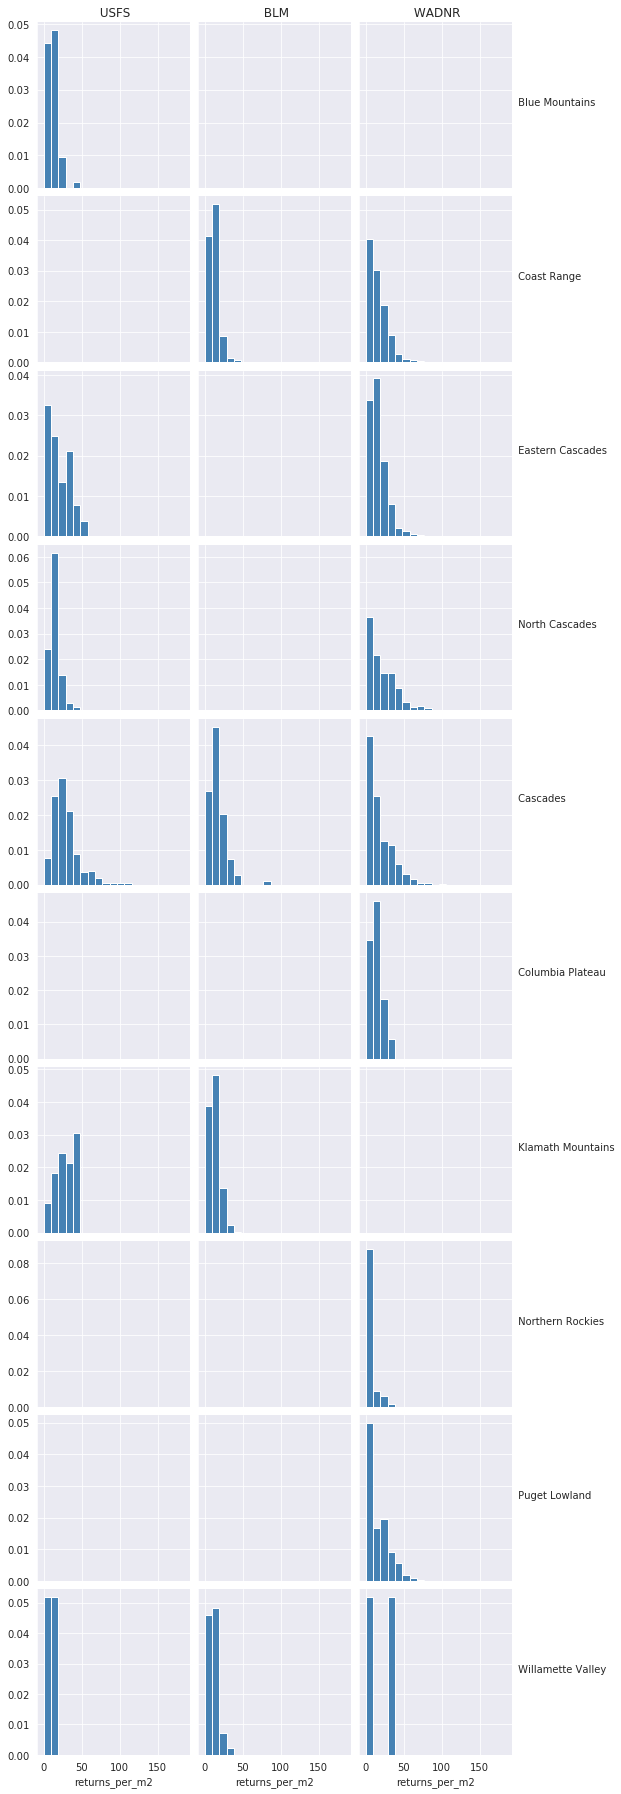

In [56]:
plot_grid(annual_data, 'returns_per_m2')